# PROJECT

### Import Statements

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import imageio
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from IPython.display import clear_output

### Calibration

In [ ]:
def calibrate(folder  = [], x = 9, y = 6):
    """
    The calibrate functions run openCV camera calibration on checkerboard images.
    The function takes in a folder location, and attempts to read and locate checkerboards on all images of 
    type jpg jpeg or png.
    The checkers default to 9x6 configuration.
    
    The main modification in this function is the use of openCV's built-in image processing 
    functions for corner detection using the CALIB_CB flags. Thus, with this pre-processing enabled,
    the calibration function takes in color images, and allows openCV to do the processing.
    
    It was noted that using gray images had poor results with cv2.findChessboardCorners.
    """
    # get list of all files in folder
    files = glob.glob(folder + '/*')
    object_points = np.zeros((y*x,3),np.float32)
    object_points[:,:2] = np.mgrid[0:x,0:y].T.reshape(-1,2)
    corners = []
    obj_points = []
    im_used = 0;
    for f in files:
        if f.split('.')[-1] in ['jpg','jpeg','png']:
            # load image:
            im = cv2.imread(f)
            # using gray image resulted in issues, so implemented cv's pre-processing
            ret, im_corner = cv2.findChessboardCorners(im, (x,y),  cv2.CALIB_CB_ADAPTIVE_THRESH | cv2.CALIB_CB_NORMALIZE_IMAGE)
            if im_corner is not None and len(im_corner) == x*y:
                corners.append(im_corner)
                obj_points.append(object_points)
                im_used +=1
    # run calibration:
    if im_used>0:
        print("Using {} images for calibration.".format(im_used))
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, corners, im.shape[::-1], None, None)  
        return mtx, dist, rvecs, tvecs
    else:
        print("No Images can be used! change parameters!")
        return 0,0,0,0

### Undistortion

In [ ]:
def undistort(img, c, dist):
    # img -> opencv image
    # c -> camera calirbation matrix
    # dist -> distortion coefficients
    return cv2.undistort(img, c, dist, None, c)

### Calibration wrapper

In [ ]:
def calibration_wrapper(calib_folder = 'camera_cal'):
    """
    This function is a camera calibration wrapper that tries to load camera calibration file.
    If the calibration file does not exist, it will run camera calibration.
    """
    try:
        calibration_data = pickle.load( open( calib_folder + "/calib.p", "rb" ) )
        c = calibration_data["camera_matrix"]
        dist = calibration_data["distortion_coefficients"]
        r = calibration_data["rotation_vectors"]
        t = calibration_data["translation_vectors"]
        print('calibration data loaded')
    except:
        # calibration load failed:
        print('No calibration file found, calibrating')
        c, dist, r, t = calibrate(folder = calib_folder,x = 9, y = 6)
        calibration_data = {"camera_matrix": c, "distortion_coefficients": dist, "rotation_vectors":r, "translation_vectors": t}
        pickle.dump( calibration_data, open( calib_folder + "/calib.p", "wb" ) )
        print('Calibration Complete')
    return c, dist, r, t

### Warping

In [ ]:
# Image transform:
def warper(img, M):
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    return warped

### Get Warping Parameters

In [ ]:
def generate_projection(img_size):
    """
    This function generates the perspective projection matrix M using 4 source points and 4 destination points.
    The source points were manually chosen by analyzing the straight_lines image. 
    The destinatation points were arbitrarily chosen using the guides in the lecture notes.
    """
    src = np.float32(
    [[580, 458],
    [194, 720],
     [1140,720],
    [705, 458]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    M = cv2.getPerspectiveTransform(src, dst)
    return M, src, dst

### Image Processing

In [ ]:
def generic_threshold(img, thresh = []):
    """
    generic threshold method.
    Applies each threshold pair on image independently and returns images list with each threshold applied.
    """
    
    if type(thresh) is list:
        binary = []
        for t in thresh:
            temp = np.zeros_like(img)
            temp[(img >= t[0]) & (img <= t[1])] = 1
            binary.append(temp)
    else:
        binary = np.zeros_like(img)
        binary[(img >= thresh[0]) & (img <= thresh[1])] = 1
    
    return binary

In [ ]:
def apply_sobel(img, direction = 'x'):
    # Sobel x
    if direction == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0) # Take the derivative in x
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1) # Take the derivative in y
    
    abs_sobel = np.absolute(sobel) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    return scaled_sobel

In [ ]:
def sobel_x(img, thresh = (20,100)):
    """
    Method for returning binary gradient thresholding using sobel detector in x-direction.
    This method allows for multiple threshold ranges.
    """
    # Sobel x
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    # if the thresh object is a list of tuples, apply each threshold pair individually
    if type(thresh) is list:
        for t in thresh:
            sxbinary[(scaled_sobel >= t[0]) & (scaled_sobel <= t[1])] = 1
    else:
        sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return sxbinary
    

In [ ]:
def color_thresholding(img, thresh = (170,255)):
    """
    Method for returning binary color thresholding using sobel detector in x-direction.
    This method allows for multiple threshold ranges.
    """
     # Threshold color channel
    s_binary = np.zeros_like(img)
    # allow for multiple color thresholds:
    if type(thresh) is list:
        for t in thresh:
            s_binary[(img >= t[0]) & (img <= t[1])] = 1
    else:
        s_binary[(img >= thresh[0]) & (img <= thresh[1])] = 1
        
    return s_binary
    

In [ ]:
def thresholding_DEP(img, g_thresh = (20,100), c_thresh = (170,255)):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    # added lightness thresholding on L channel to remove black, or very dark values
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    sxbinary = sobel_x(l_channel, thresh = g_thresh)

    s_binary = color_thresholding(s_channel,thresh = c_thresh)
    l_binary = color_thresholding(l_channel,thresh = (100,255))
    
    c_binary = np.zeros_like(img)
    c_binary = s_binary*l_binary;
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, c_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((s_binary == 1) & (l_binary == 1)) | (sxbinary == 1)] = 1
    return combined_binary, color_binary

In [ ]:
def thresholding(img, g_thresh = (20,100), c_thresh = (170,255)):
    """
    thesholding function for gradients and colors.
    This function operates on HLS space to improve separation between pixel brightness and color.
    
    Gradient operation is done in L-space
    
    Color thresholding is done in S and L space as the union of a color threshold and lightness threshold
    to remove false lane detections in shadow conditions.
    """
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    # added lightness thresholding on L channel to remove black, or very dark values
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # apply sobel operator in x-direction:
    sobel = apply_sobel(hls[:,:,1])
    # threshold sobel image:
    sx_binary = generic_threshold(sobel,thresh = (20,100))
    # apply color threshold:
    s_binary = generic_threshold(hls[:,:,2],thresh = c_thresh)
    # apply lightness threshold:
    l_binary = generic_threshold(hls[:,:,1],thresh = (100,255))
    # create new matrix for color thresholding binary:
    c_binary = np.zeros_like(img)
    # take union of color thresholding and lightness thresholding:
    c_binary = s_binary*l_binary;
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sx_binary), sx_binary, c_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[(c_binary == 1) | (sx_binary == 1)] = 1
    return combined_binary, color_binary

### Convolution Lane Detection

In [539]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        if conv_signal[l_min_index:l_max_index].sum() ==0:
            print('Left Zero')
        else:
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        if conv_signal[r_min_index:r_max_index].sum() ==0:
            print('Right Zero')
        else:
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

def detect_lanes(warped_image = [], undist = [], window_width = [], plots = False, window_height = [], margin = [], M = [], rlane = [], llane = []):
    window_centroids = find_window_centroids(warped_image, window_width, window_height, margin)
    # If we found any window centers
    if len(window_centroids) > 0:
        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped_image)
        r_points = np.zeros_like(warped_image)
        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped_image,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped_image,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
            # TODO: grab pixels from warped that are in each side's window!

        # Draw the results - EN MAY NOT NEED IT!
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage= np.dstack((warped_image, warped_image, warped_image))*255 # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

        # If no window centers found, just display orginal road image
    else:
        # TODO, estimate lane positions
        return None, None, None

    # now, AND the L/R windows with the binary image to get all hot pixels in L/R tracks:
    l_hits = np.zeros_like(warped_image)
    l_hits[np.logical_and(l_points,warped_image)] = 1
    # fast way:
    l_coord = np.argwhere(np.logical_and(l_points,warped_image))

    r_hits = np.zeros_like(warped_image)
    r_hits[np.logical_and(r_points,warped_image)] = 1
    # fast way:
    r_coord = np.argwhere(np.logical_and(r_points,warped_image)) #format (y,x)
    # now, can use l_hits, r_hits to fit polynomial




    # Fit a second order polynomial to pixel positions in each fake lane line
    ploty = np.linspace(0, 719, num=720)
    left_fit = np.polyfit(l_coord[:,0], l_coord[:,1], 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(r_coord[:,0], r_coord[:,1], 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
#     print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48
    # Use the x-pixels from line fit to get approximate equavalent 
    lane_width_px = right_fitx[0]-left_fitx[0]
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
#     xm_per_pix = 3.7/700 # meters per pixel in x dimension
    xm_per_pix = 3.7/lane_width_px # meters per pixel in x dimension
    
    # car location on lane:
    car_offset = xm_per_pix*((undist.shape[1] - lane_width_px)/2 - left_fitx[0])
    
#     print(right_fitx[0]-left_fitx[0])

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    #PLOTTING--------------------------------------
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    color_warp_lane = np.dstack((l_hits, warp_zero, r_hits))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, np.linalg.inv(M), (image.shape[1], image.shape[0]))
    newwarplane = cv2.warpPerspective(color_warp_lane, np.linalg.inv(M), (image.shape[1], image.shape[0]))
    # Combine the result with the original image
    output_image = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    output_image = cv2.addWeighted(output_image, 1, newwarplane, 0.3, 0)
    prompt1 = 'Left Curve: {:0.2f} [m]'.format(left_curverad)
    prompt2 = 'Right curve: {:0.2f} [m]'.format(right_curverad)
    prompt3 = 'offset: {:0.2f} [m]'.format(car_offset)
    cv2.putText(output_image,prompt1,(5,40), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(output_image,prompt2,(5,80), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(output_image,prompt3,(5,120), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),2,cv2.LINE_AA)
    # TODO: unwarp L/R lane pixels & color them on original image...
    if plots:
        # Display the final results
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()

        ax1.imshow(warped_image)
        ax1.set_title('Original Image', fontsize=40)

        ax2.imshow(output)
        ax2.set_title('Pipeline Result', fontsize=40)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#         f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#         f.tight_layout()

#         ax1.imshow(l_points)
#         ax1.set_title('Original Image', fontsize=40)

#         ax2.imshow(r_points)
#         ax2.set_title('Pipeline Result', fontsize=40)
#         plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#         f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#         f.tight_layout()

#         ax1.imshow(l_hits)
#         ax1.set_title('Original Image', fontsize=40)

#         ax2.imshow(r_hits)
#         ax2.set_title('Pipeline Result', fontsize=40)
#         plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


        plt.figure()
        ax = plt.gca()
        ax.plot(l_coord[:,1], l_coord[:,0], 'o', color='red', markersize=mark_size)
        ax.plot(r_coord[:,1], r_coord[:,0], 'o', color='blue', markersize=mark_size)
        ax.set_xlim(0, 1280)
        ax.set_ylim(0, 720)
        ax.plot(left_fitx, ploty, color='green', linewidth=3)
        ax.plot(right_fitx, ploty, color='green', linewidth=3)
        ax.invert_yaxis() # to visualize as we do the images
        ax.set_title('Original Image', fontsize=40)

    return output_image


### Lane Class

In [ ]:
class lane():
    """
    This is a smoothing tracker class to track left/right lanes individually.

    """
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

### Lane Detector Class

In [ ]:
class lane_detector():
    """
    Lane tracker is an object that tracks both left and right lanes.
    It processes images, runs lane detection pipe-line, and makes an estimate as to
    which lines correspond to Left/Right lanes.
    Lanes are stored as (m,b) line variables with 'soft' tracking enabled such that
    position is filtered to ensure smoothness

    """
    def __init__(self,c = [],dist = [],img_size = []):
        self.r_lane = lane()
        self.l_lane = lane()
        self.camera_matrix = c
        self.camera_dists  = dist
        self.M = []
    
    """
    This call back function takes in an image, detects lane regions, and returns an image with colored lanes.
    """
    def process(self,image):
        # Generate perspective projection matrix:
        if self.M is None:
            self.M, self.src, self.dst = generate_projection(image.shape[:2][::-1])
        # first undistort image:
        undistorted_image = undistort(image,self.camera_matrix,self.camera_dists)
        # Next, apply thresholding:
        binar_image, _ = thresholding(undistorted_image, g_thresh = (20,120), c_thresh = (110,255))
        #  warp the image:
        warped_image = warper(binar_image,M)
        # TODO: DEFINE THIS FUNCTION!
        output_image = detect_lanes(warped_image = warped_image,undist = image, window_width = 50, window_height = 80, margin = 60, M = M)
        return output_image

# Video Processing Framework

In [ ]:
fileName = 'project_video.mp4'
write_output = 'output_images/' + fileName
clip1 = VideoFileClip(fileName)
firstImage = clip1.get_frame(0)
# load camera calibration:
c, dist, rvects, tvects = calibration_wrapper()
# make lane tracker object:
detector = lane_detector(c = c,dist = dist,img_size = firstImage.shape)
white_clip = clip1.fl_image(detector.process)
white_clip.write_videofile(write_output, audio=False)

# TODO:
# ADD SMOOTHING FROM PREVIOUS FRAME for each lane; reject lanes if they are too far off previous!

## Simple file read approach

In [ ]:
fileName = 'project_video.mp4'
vid = imageio.get_reader(fileName,  'ffmpeg')
for i in range(0,vid.get_length()):
    clear_output()
    image = vid.get_data(num)
    fig = plt.figure(1)
    plt.close(1)
    plt.clf()
    fig.suptitle('image #{}'.format(num), fontsize=20)
    ax = plt.gca()
    ax.imshow(image)
    plt.show()

## Demos & Figure Generation
All functions for figure generation are contianed herein

In [ ]:
# CALIBRATION UNDISTORTION
# SOBEL & Gradient Operator
# Unwarping
# Lane Detector
# Processor output w/ curvature & car pose

In [ ]:
import sys
print(sys.executable)
pickle.load( open( "camera_cal/calib.p", "rb" ) )

### Demo Calibration

In [ ]:
def demo_calibration(fileName,saveName):
    # run calibraiton wrapper to get calibration data:
    c, dist, rvects, tvects = calibration_wrapper()
    # test calibration undistort
    image = mpimg.imread(fileName)
    result = undistort(image, c,dist)
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=40)
    ax1.axis('off')

    ax2.imshow(result)
    ax2.set_title('Undistorted Result', fontsize=40)
    ax2.axis('off')

    if len(saveName)>0:
        plt.savefig(saveName, bbox_inches='tight')
        

demo_calibration('camera_cal/calibration3.jpg', 'output_images/demo_calibration.png')

### Demo Image Processing

In [ ]:
def demo_processing(fileName,saveName):
    # Load image of straight lines:
    image = mpimg.imread(fileName)
    image = undistort(image,c,dist)
    M, src, dst = generate_projection(image.shape[:2][::-1])
    binary, result = thresholding(image, g_thresh = (20,100), c_thresh = (175,255))
    # Plot the result
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=40)
    ax1.axis('off')

    ax2.imshow(result)
    ax2.set_title('Pipeline Result', fontsize=40)
    ax2.axis('off')

    ax3.imshow(binary)
    ax3.set_title('Pipeline Binary', fontsize=40)
    ax3.axis('off')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    if len(saveName)>0:
        plt.savefig(saveName, bbox_inches='tight')


demo_processing('test_images/straight_lines1.jpg', 'output_images/demo_processing_00.png')
demo_processing('test_images/straight_lines2.jpg', 'output_images/demo_processing_00.png')
demo_processing('test_images/test1.jpg', 'output_images/demo_processing_01.png')
demo_processing('test_images/test2.jpg', 'output_images/demo_processing_01.png')
demo_processing('test_images/test3.jpg', 'output_images/demo_processing_01.png')
demo_processing('test_images/test4.jpg', 'output_images/demo_processing_01.png')
demo_processing('test_images/test5.jpg', 'output_images/demo_processing_01.png')
demo_processing('test_images/test6.jpg', 'output_images/demo_processing_01.png')

### Demo Unwarping

In [ ]:
def demo_unwarpping(fileName,saveName):
    # Load image of straight lines:
    image = mpimg.imread(fileName)
    image = undistort(image,c,dist)
    M, src, dst = generate_projection(image.shape[:2][::-1])
    # add lines to image:
    processed_img = warper(image,M)
    # add lines to original:
    cv2.line(image,tuple(src[1,:]),tuple(src[0,:]),(255,0,0),5)
    cv2.line(image,tuple(src[2,:]),tuple(src[3,:]),(255,0,0),5)
    cv2.line(image,tuple(src[3,:]),tuple(src[0,:]),(255,0,0),5)
    # add lines to warped:
    # cv2.line(processed_img,(dst[0,0],dst[0,1]),(dst[1,0],dst[1,1]),(255,0,0),5)
    # cv2.line(processed_img,(dst[2,0],dst[2,1]),(dst[3,0],dst[3,1]),(255,0,0),5)
    cv2.line(processed_img,tuple(dst[0,:]),tuple(dst[1,:]),(255,0,0),5)
    cv2.line(processed_img,tuple(dst[2,:]),tuple(dst[3,:]),(255,0,0),5)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=40)
    ax1.axis('off')

    ax2.imshow(processed_img)
    ax2.set_title('Wrapped Image', fontsize=40)
    ax2.axis('off')
    # save figure:
    plt.savefig(saveName, bbox_inches='tight')

demo_unwarpping('test_images/straight_lines2.jpg', 'output_images/demo_warpping_00.png')
demo_unwarpping('test_images/test1.jpg', 'output_images/demo_warpping_01.png')

### Demo Processing & Warpping

In [ ]:
def demo_process_wrap(fileName,saveName = []):
    # Load image of straight lines:
    image = mpimg.imread(fileName)
    # undistort image:
    image = undistort(image,c,dist)
    # load perspective projection warp:
    M, src, dst = generate_projection(image.shape[:2][::-1])
    # process image:
    binary, result = thresholding(image, g_thresh = (20,100), c_thresh = (170,255))
    # warp image:
    result = warper(binary, M)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=40)
    ax1.axis('off')

    ax2.imshow(result)
    ax2.set_title('Processed Image', fontsize=40)
    ax2.axis('off')
    # save figure:
    if len(saveName)>0:
        plt.savefig(saveName, bbox_inches='tight')
    

demo_process_wrap('test_images/straight_lines1.jpg', 'output_images/demo_process_wrap_0.png')
demo_process_wrap('test_images/straight_lines2.jpg')
demo_process_wrap('test_images/test1.jpg', 'output_images/demo_process_wrap_1.png')
demo_process_wrap('test_images/test2.jpg')
demo_process_wrap('test_images/test3.jpg')
demo_process_wrap('test_images/test4.jpg')
demo_process_wrap('test_images/test5.jpg')
demo_process_wrap('test_images/test6.jpg')

### Demo Lane Detector

Right Zero
4910.99272781 m 4607.74059672 m
Right Zero
Right Zero
Left Zero
Left Zero
1386.43283777 m 562.310762739 m


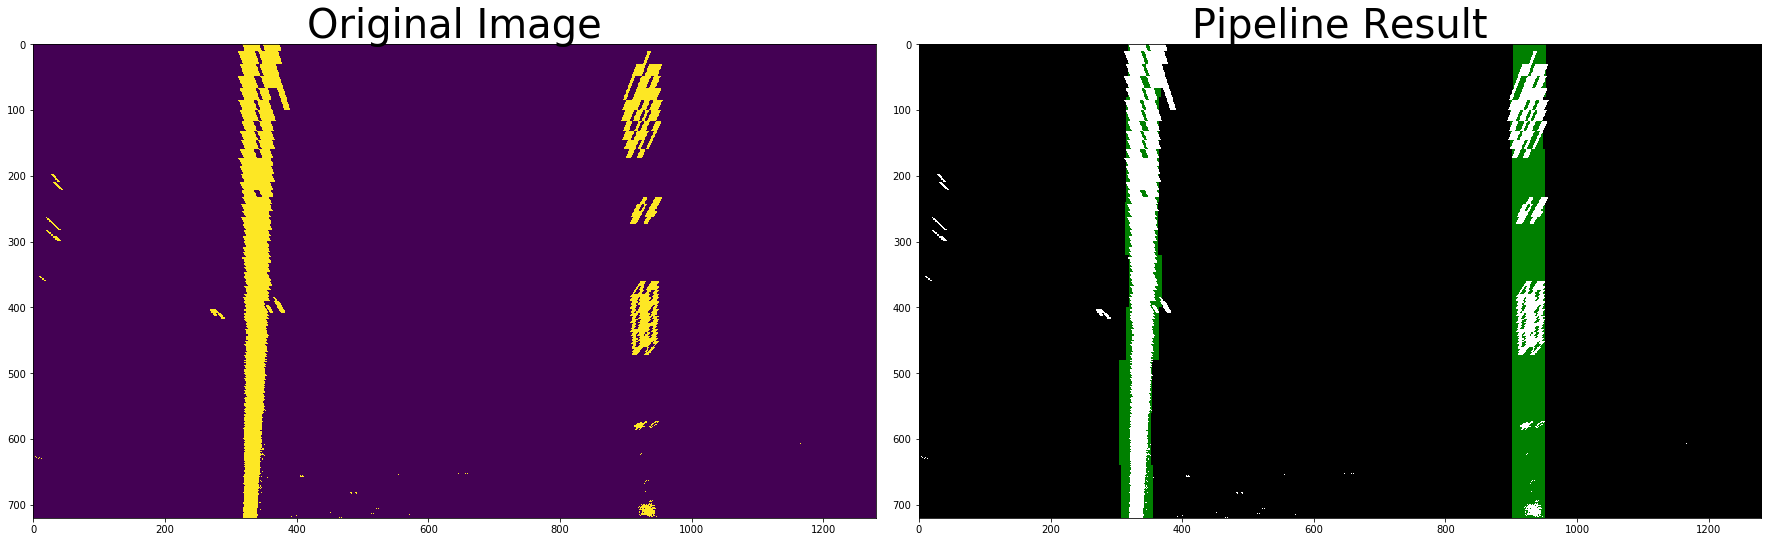

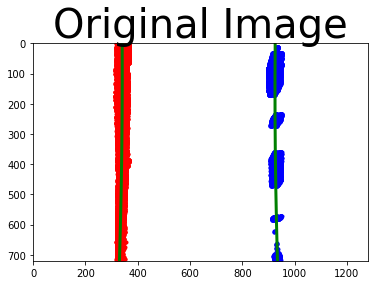

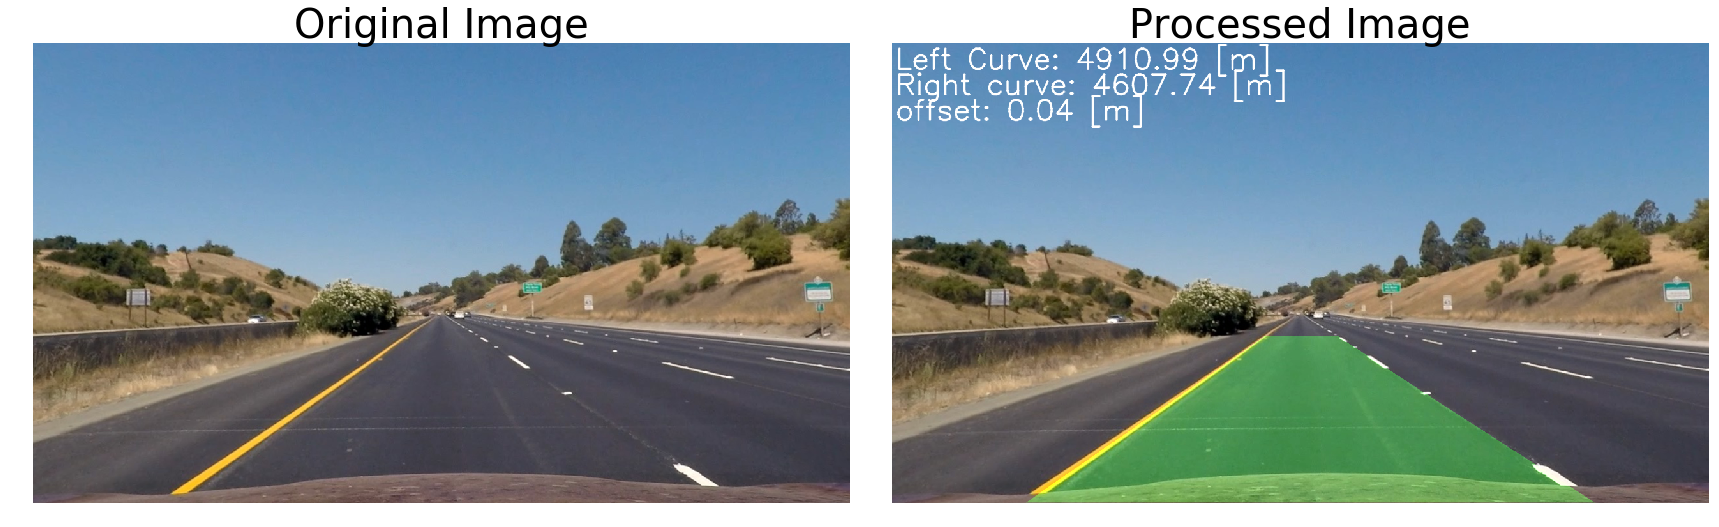

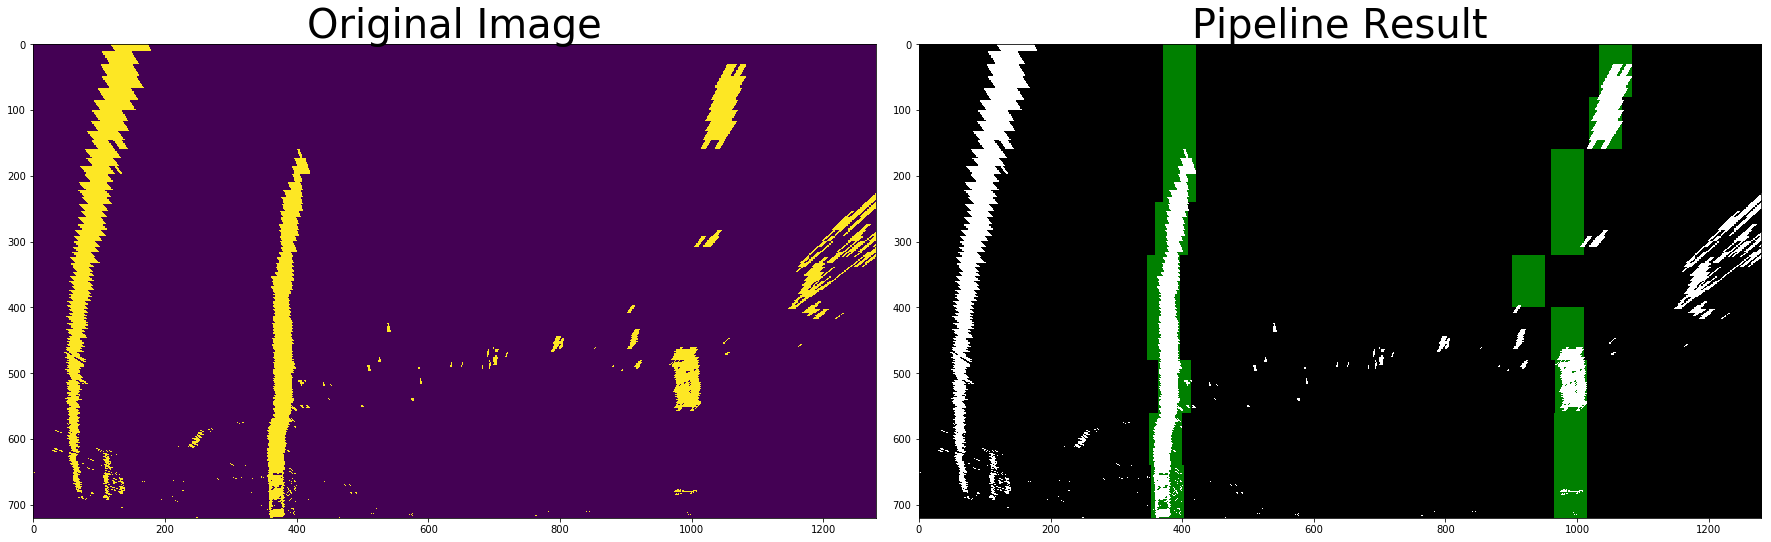

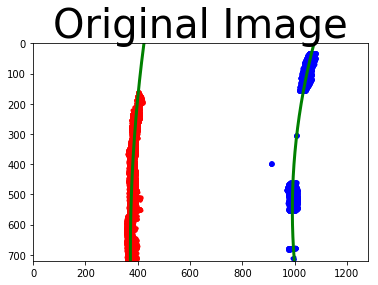

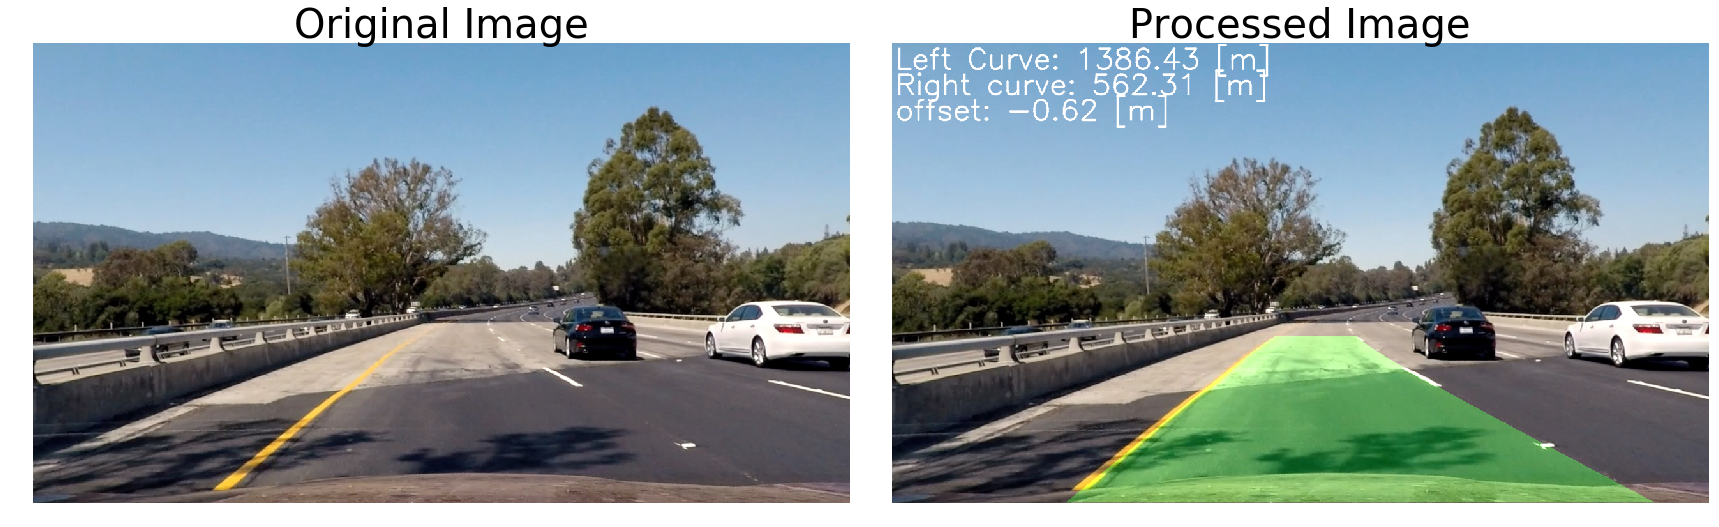

In [541]:
def demo_lane_detector(fileName,saveName):
    # Load image of straight lines:
    image = mpimg.imread(fileName)
    image = undistort(image,c,dist)
    M, src, dst = generate_projection(image.shape[:2][::-1])
    # first undistort image:
    undistorted_image = undistort(image,c,dist)
    # Next, apply thresholding:
    binary_image, _ = thresholding(undistorted_image, g_thresh = (20,100), c_thresh = (170,255))
    #  warp the image:
    warped_image = warper(binary_image,M)
    # TODO: DEFINE THIS FUNCTION!
    output_image = detect_lanes(warped_image = warped_image, plots = True, undist = image, window_width = 50, window_height = 80, margin = 60, M = M)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=40)
    ax1.axis('off')

    ax2.imshow(output_image)
    ax2.set_title('Processed Image', fontsize=40)
    ax2.axis('off')
    if len(saveName)>0:
        plt.savefig(saveName, bbox_inches='tight')
    

demo_lane_detector('test_images/straight_lines1.jpg', 'output_images/demo_warpping_00.png')
# demo_lane_detector('test_images/straight_lines2.jpg', 'output_images/demo_warpping_00.png')
# demo_lane_detector('test_images/test1.jpg', 'output_images/demo_warpping_01.png')
# demo_lane_detector('test_images/test2.jpg', 'output_images/demo_warpping_01.png')
# demo_lane_detector('test_images/test3.jpg', 'output_images/demo_warpping_01.png')
demo_lane_detector('test_images/test4.jpg', 'output_images/demo_warpping_01.png')
# demo_lane_detector('test_images/test5.jpg', 'output_images/demo_warpping_01.png')
# demo_lane_detector('test_images/test6.jpg', 'output_images/demo_warpping_01.png')

### Demo Full Processing Pipeline